# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = './Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

In [2]:
import glob
import pandas as pd
import numpy as np
import random
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline  


sns.set_style("dark")

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### General

We first import a few modules that we will use through out this task. We also define some utility functions, their goal is either self described by their names or contained in the docstring.

In [3]:
def files_for_country(c):
    pattern = '{}/ebola/{}_data/*.csv'.format(DATA_FOLDER, c)
    return glob.glob(pattern)


def row_description_file_analysis(df, data_field='Description', file_field='File'):
    """For a given dataframe, count the occurentces of a data_field in each file"""
    df = df.copy()
    df = df[[data_field, file_field]]
    df['Count'] = 1
    df = df.groupby([data_field, file_field]).sum()
    df = df.reset_index()
    pivot = df.pivot(index=data_field, columns=file_field, values='Count')
    pivot.fillna(value=0.0, inplace=True)
    return pivot


def scatter_plot_pivot(pivot, radius=40):
    """Plot a grid for columns and index of a DF with point proportional to the value"""
    n_row = len(pivot.index)
    n_col = len(pivot.columns)
    range_row = np.arange(0, n_row)
    range_col = np.arange(0, n_col)
    xs, ys = np.meshgrid(range_col, range_row, sparse=False, indexing='ij')
    fig, ax = plt.subplots(figsize=(int(n_col / 4), int(n_row / 3)))
    ax.scatter(xs.ravel(), ys.ravel(), s=np.transpose(pivot.values).ravel() * radius)
    ax.set_xticklabels(pivot.columns)
    ax.xaxis.tick_top()
    plt.xticks(range_col, rotation=90)
    plt.yticks(range_row)
    ax.set_yticklabels(pivot.index)
    plt.show()


def import_df(country, with_filename=True, date_fields=None):
    """Parse and concat all the files for a country"""
    files = files_for_country(country)
    dfs = []
    for f in files:
        df = pd.read_csv(f, parse_dates=date_fields)
        if with_filename:
            df['File'] = f
        dfs.append(df)

    df_full: pd.DataFrame = pd.concat(dfs, ignore_index=True)
    df_full = df_full.fillna(0)
    df_full['Country'] = country
    return df_full


def split_year_month(df, date_field='Date'):
    """Add Year and Month column to the DF extracted from a date column"""
    df['Year'] = df[date_field].apply(lambda d: d.year)
    df['Month'] = df[date_field].apply(lambda d: d.month)


We will tackle one country at a time, because their CSV files are quite unhomogeneous and we need to uniformize this before merging the dataframes together.

### Guinea

We first import all the files for Guinea. Given that we are not asked to do an analysis by region we only project the 'Country' level and we drop the other columns. 

In [4]:
guinea = import_df('guinea', date_fields=['Date'])

# We do a sanity check that the Totals columns has been correctly computed for each row
guinea = guinea[guinea.Description != 'Fatality rate for confirmed and probables'].copy()
guinea_counts = guinea.drop(['Date', 'Description', 'File', 'Country', 'Totals'], axis=1).astype(np.int)
guinea_totals = guinea_counts.sum(axis=1)
guinea.Totals = guinea.Totals.astype(np.int)
guinea['Total_check'] = guinea_totals
guinea['Diff'] = guinea.Totals - guinea['Total_check']
guinea['AbsDiff'] = (guinea.Totals - guinea['Total_check']).abs()
guinea.loc[guinea.Diff != 0,['Date', 'Description', 'Totals', 'Total_check', 'Diff', 'AbsDiff']].sort_values(by='AbsDiff', ascending=False)

,Date,Description,Totals,Total_check,Diff,AbsDiff
233,2014-09-04,Total samples tested,249,2086,-1837,1837
41,2014-08-04,Number of samples collected,1235,0,1235,1235
98,2014-08-27,Total contacts registered from start date,7662,6519,1143,1143
707,2014-10-01,Number of contacts to follow today,2661,3561,-900,900
40,2014-08-04,Number of patients tested,785,0,785,785
101,2014-08-27,Number of contacts out of the track 21 days,6496,5762,734,734
99,2014-08-27,Number of contacts to follow today,1264,866,398,398
100,2014-08-27,Number of contacts followed today,1250,863,387,387
629,2014-09-26,Total deaths of probables,494,169,325,325
630,2014-09-26,Total deaths of confirmed,668,494,174,174


To handle the inconsistancy between the sum of the regions and the given Totals column, we have investigated the following method:

- keep the Total already computed (method we chose): implies that we trust their computation, simple,
- take our recomputed total: maybe some cases could not be linked to a particular region and where added to the national directly,
- take the mean: not very meaningful,
- keep the max (the method we chose)
- keep the min.

Given that the differences are not very significative, we chose to keep the already computed Totals column. 

We select the columns that we are interested in.

In [5]:
guinea = guinea[['Date', 'Description', 'Country', 'Totals', 'File']]
guinea.head()

,Date,Description,Country,Totals,File
0,2014-08-04,New cases of suspects,guinea,5,./Data/ebola/guinea_data/2014-08-04.csv
1,2014-08-04,New cases of probables,guinea,0,./Data/ebola/guinea_data/2014-08-04.csv
2,2014-08-04,New cases of confirmed,guinea,4,./Data/ebola/guinea_data/2014-08-04.csv
3,2014-08-04,Total new cases registered so far,guinea,9,./Data/ebola/guinea_data/2014-08-04.csv
4,2014-08-04,Total cases of suspects,guinea,11,./Data/ebola/guinea_data/2014-08-04.csv


To get a better understanding of the row (description) contained in each file, we visualize the fields by file with a blue point in the following figure. You can click to visualize it in the right size. Also note that if a field is contained twice in a file, the point will be twice bigger.

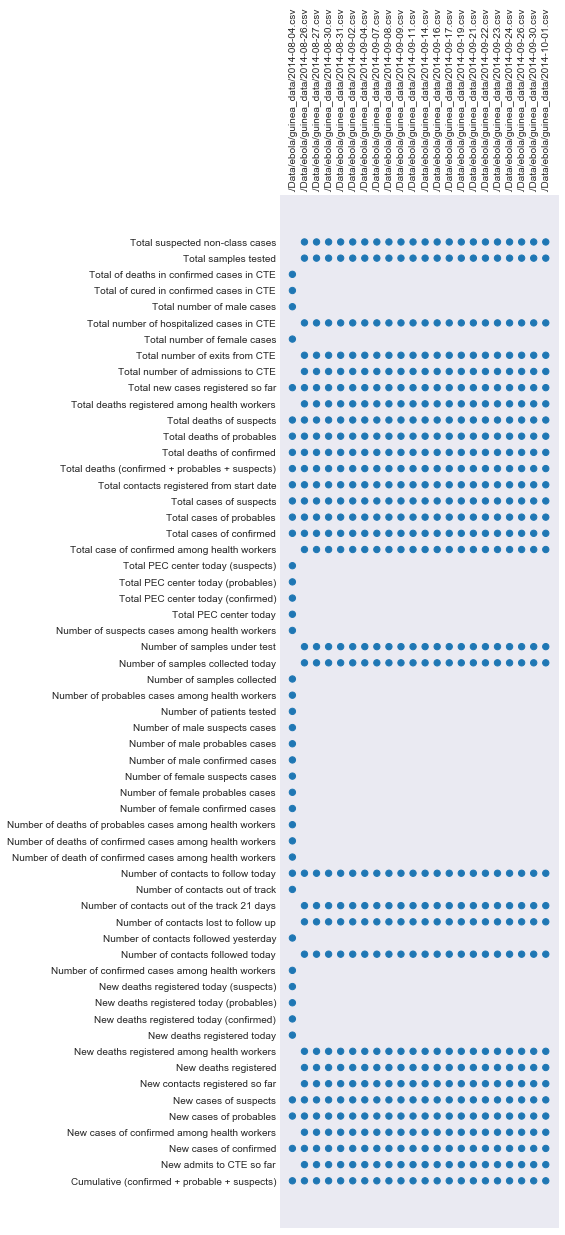

In [6]:
# Analysis of the rows in each CSV file
piv = row_description_file_analysis(guinea)
scatter_plot_pivot(piv)

We want to compute the daily average per month of new cases and deaths. From the previous visualization we can pick the row that interest us.

- New deaths
    * For most of the files we will look at the described as **New deaths registered**
    * For 2014-08-04 we will pick the field **New deaths registered today** instead
    * We assume that 'New deaths registered among health workers' are already counted in 'New deaths registered'
- New cases
    * Accorcding to this [explanation](http://avianflunetwork.blogspot.ch/2009/04/case-classifications-what-are-suspected.html) of the differences between suspected, probable, confirmed cases. We decide to count the confirmed cases only. They are the 100% sure cases, so it makes sense. Summing/averaging the 3 types would not make sense because some people would be counted multiple times.
    * We will look at **New cases of confirmed**
    
We define the `mean_new_case_and_deaths` function that will be reused for the other countries.

In [7]:
def mean_new_case_and_deaths(df, new_desc, death_desc):
    """
    Extract new_desc fields for new cases and death_desc fields for new deaths, aggregate by month and
    compute average daily count.
    """
    new_df = df.query('Description in @new_desc').copy()
    new_df.loc[:, 'Description'] = 'New case'
    death_df = df.query('Description in @death_desc').copy()
    death_df.loc[:, 'Description'] = 'Death'

    result: pd.DataFrame = pd.concat([new_df, death_df])

    split_year_month(result)
    result.Totals = pd.to_numeric(result.Totals)
    result = result.rename(columns={'Totals': 'Daily average'})
    return result.groupby(['Country', 'Description', 'Year', 'Month']).mean()

In [8]:
guinea_rates = mean_new_case_and_deaths(guinea, 
                                        new_desc=['New cases of confirmed'], 
                                        death_desc=['New deaths registered', 'New deaths registered today'])
guinea_rates

Daily average
Country Description Year Month               
guinea  Death       2014 8             3.4000
                         9             3.5625
                         10           15.0000
        New case    2014 8            12.4000
                         9            13.0000
                         10            6.0000

### Liberia

We follow the same procedure for Liberia. We import all the files and check which fields we can exploit to get the daily new cases and new daily deaths.

In [9]:
liberia = import_df('liberia', date_fields=['Date'])
liberia = liberia[['Date', 'Variable', 'Country', 'National', 'File']]
liberia.columns = ['Date', 'Description', 'Country', 'Totals', 'File']
liberia.head()

,Date,Description,Country,Totals,File
0,2014-06-16,Specimens collected,liberia,1.0,./Data/ebola/liberia_data/2014-06-16.csv
1,2014-06-16,Specimens pending for testing,liberia,0.0,./Data/ebola/liberia_data/2014-06-16.csv
2,2014-06-16,Total specimens tested,liberia,28.0,./Data/ebola/liberia_data/2014-06-16.csv
3,2014-06-16,Newly reported deaths,liberia,2.0,./Data/ebola/liberia_data/2014-06-16.csv
4,2014-06-16,Total death/s in confirmed cases,liberia,8.0,./Data/ebola/liberia_data/2014-06-16.csv


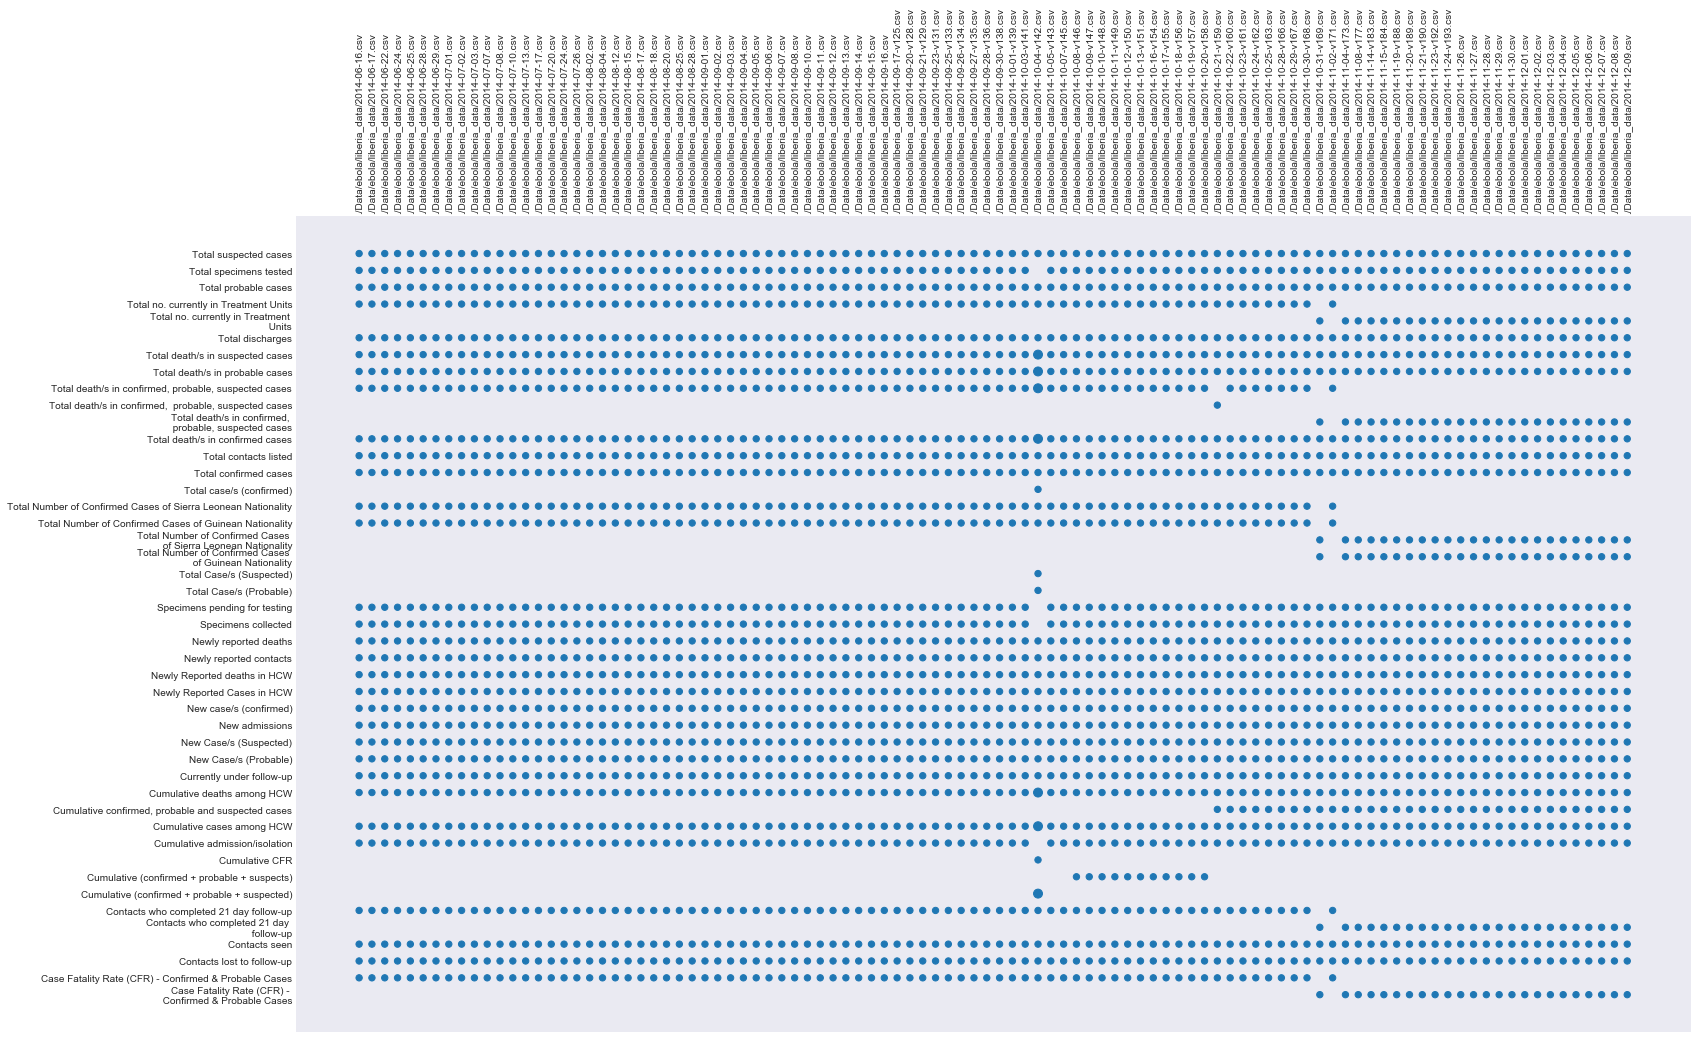

In [10]:
# Analysis of the rows in each CSV file
piv = row_description_file_analysis(liberia)
scatter_plot_pivot(piv) 

The two fields that we will be interested in are **Newly reported deaths** and **New case/s (confirmed)**. From the visualization above, we see that these fields are present in all the files and there is no duplicate (as opposed to `Total death/s in probable cases` visible by the double size dot).

In [11]:
liberia_rates = mean_new_case_and_deaths(
    liberia, 
    new_desc=['New case/s (confirmed)'], 
    death_desc=['Newly reported deaths'])
liberia_rates

Daily average
Country Description Year Month               
liberia Death       2014 6           2.000000
                         7           4.272727
                         8          23.222222
                         9          36.041667
                         10         28.040000
                         11         13.466667
                         12          0.000000
        New case    2014 6           2.142857
                         7           1.818182
                         8           5.444444
                         9           6.166667
                         10          1.360000
                         11          2.600000
                         12       1928.333333

The December daily new case average is suspicious (1928 is way too high). When looking at the data in the following notebook cell, it seems that in the last files, these rows were used for cumulative number of cases instead of new cases. We fix this manualy by picking the difference between one day and the previous one.

In [12]:
liberia.query('Description == "New case/s (confirmed)"').tail(n=15)

,Date,Description,Country,Totals,File
2697,2014-11-24,New case/s (confirmed),liberia,0.0,./Data/ebola/liberia_data/2014-11-24-v193.csv
2729,2014-11-26,New case/s (confirmed),liberia,0.0,./Data/ebola/liberia_data/2014-11-26.csv
2761,2014-11-27,New case/s (confirmed),liberia,12.0,./Data/ebola/liberia_data/2014-11-27.csv
2793,2014-11-28,New case/s (confirmed),liberia,7.0,./Data/ebola/liberia_data/2014-11-28.csv
2825,2014-11-29,New case/s (confirmed),liberia,10.0,./Data/ebola/liberia_data/2014-11-29.csv
2857,2014-11-30,New case/s (confirmed),liberia,10.0,./Data/ebola/liberia_data/2014-11-30.csv
2889,2014-12-01,New case/s (confirmed),liberia,1.0,./Data/ebola/liberia_data/2014-12-01.csv
2921,2014-12-02,New case/s (confirmed),liberia,9.0,./Data/ebola/liberia_data/2014-12-02.csv
2953,2014-12-03,New case/s (confirmed),liberia,0.0,./Data/ebola/liberia_data/2014-12-03.csv
2985,2014-12-04,New case/s (confirmed),liberia,2867.0,./Data/ebola/liberia_data/2014-12-04.csv


In [13]:
# We fix it manually, it's not very proper but that's the hacky way ;)
liberia.loc[[2985, 3017, 3049, 3081, 3113, 3145],['Totals']] = [0., 0., 2., 0., 58., 19.]
liberia.query('Description == "New case/s (confirmed)"').tail(n=15)

,Date,Description,Country,Totals,File
2697,2014-11-24,New case/s (confirmed),liberia,0.0,./Data/ebola/liberia_data/2014-11-24-v193.csv
2729,2014-11-26,New case/s (confirmed),liberia,0.0,./Data/ebola/liberia_data/2014-11-26.csv
2761,2014-11-27,New case/s (confirmed),liberia,12.0,./Data/ebola/liberia_data/2014-11-27.csv
2793,2014-11-28,New case/s (confirmed),liberia,7.0,./Data/ebola/liberia_data/2014-11-28.csv
2825,2014-11-29,New case/s (confirmed),liberia,10.0,./Data/ebola/liberia_data/2014-11-29.csv
2857,2014-11-30,New case/s (confirmed),liberia,10.0,./Data/ebola/liberia_data/2014-11-30.csv
2889,2014-12-01,New case/s (confirmed),liberia,1.0,./Data/ebola/liberia_data/2014-12-01.csv
2921,2014-12-02,New case/s (confirmed),liberia,9.0,./Data/ebola/liberia_data/2014-12-02.csv
2953,2014-12-03,New case/s (confirmed),liberia,0.0,./Data/ebola/liberia_data/2014-12-03.csv
2985,2014-12-04,New case/s (confirmed),liberia,0.0,./Data/ebola/liberia_data/2014-12-04.csv


In [14]:
liberia_rates = mean_new_case_and_deaths(
    liberia, 
    new_desc=['New case/s (confirmed)'], 
    death_desc=['Newly reported deaths'])
liberia_rates

Daily average
Country Description Year Month               
liberia Death       2014 6           2.000000
                         7           4.272727
                         8          23.222222
                         9          36.041667
                         10         28.040000
                         11         13.466667
                         12          0.000000
        New case    2014 6           2.142857
                         7           1.818182
                         8           5.444444
                         9           6.166667
                         10          1.360000
                         11          2.600000
                         12          9.888889

### Sierra Leone

Last but not least, we take care of Sierra Leone, the process is the same.

In [15]:
sl = import_df('sl', date_fields=['date'])
sl = sl[['date', 'variable', 'Country', 'National', 'File']]
sl.columns = ['Date', 'Description', 'Country', 'Totals', 'File']
sl.head()

,Date,Description,Country,Totals,File
0,2014-08-12,population,sl,6348350,./Data/ebola/sl_data/2014-08-12-v77.csv
1,2014-08-12,new_noncase,sl,4,./Data/ebola/sl_data/2014-08-12-v77.csv
2,2014-08-12,new_suspected,sl,10,./Data/ebola/sl_data/2014-08-12-v77.csv
3,2014-08-12,new_probable,sl,1,./Data/ebola/sl_data/2014-08-12-v77.csv
4,2014-08-12,new_confirmed,sl,11,./Data/ebola/sl_data/2014-08-12-v77.csv


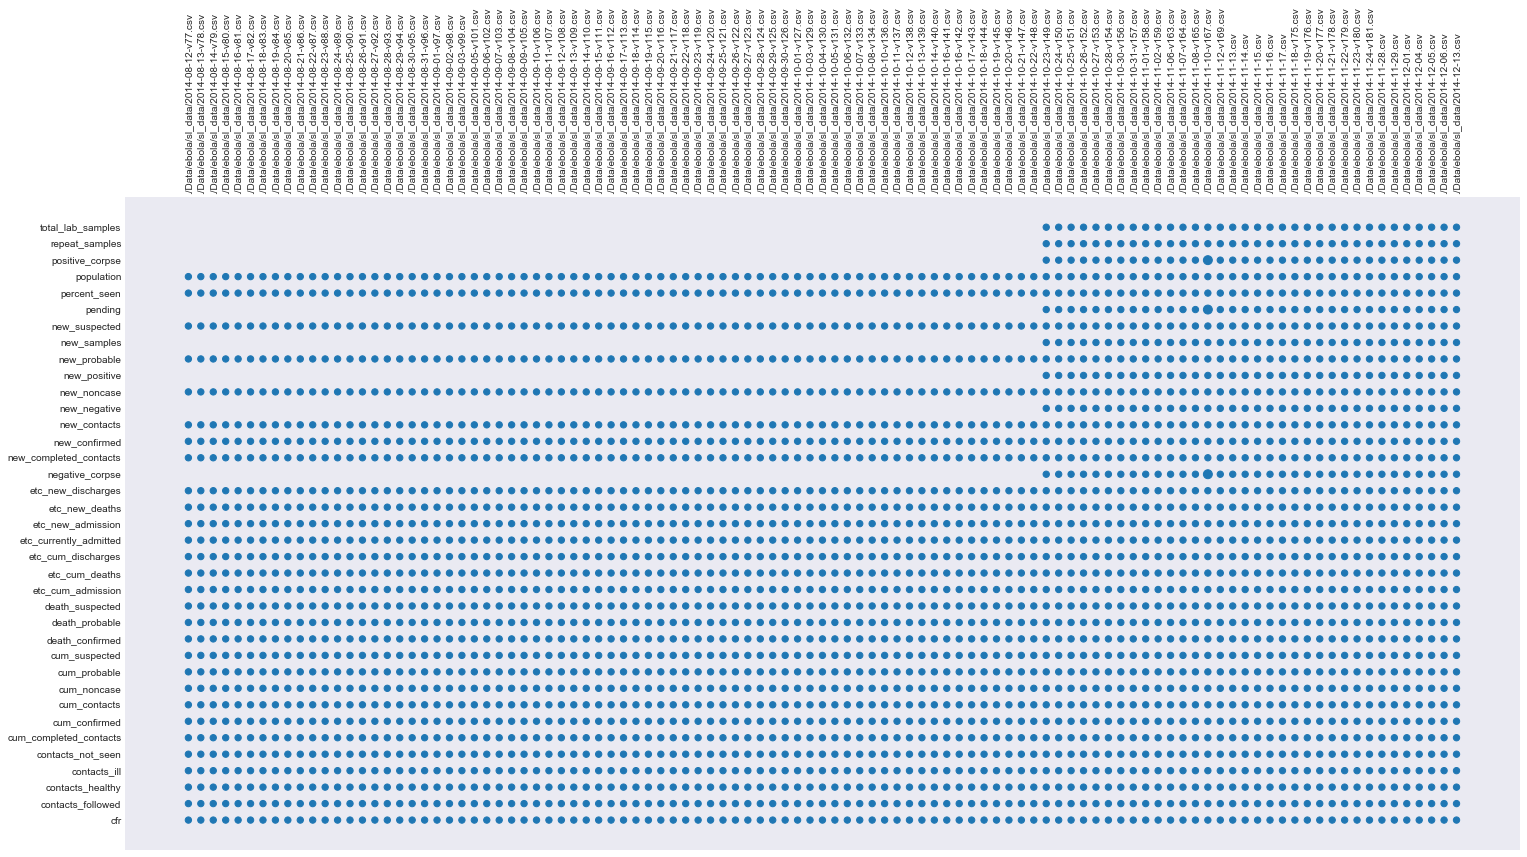

In [16]:
# Analysis of the rows in each CSV file
piv = row_description_file_analysis(sl)
scatter_plot_pivot(piv) 

In [17]:
sl_rates = mean_new_case_and_deaths(
    sl, 
    new_desc=['new_confirmed'], 
    death_desc=['death_confirmed'])
sl_rates

Daily average
Country Description Year Month               
sl      Death       2014 8         293.850000
                         9         443.310345
                         10        905.464286
                         11       1122.904762
                         12       1314.800000
        New case    2014 8          18.550000
                         9          34.413793
                         10         56.714286
                         11         59.904762
                         12         32.600000

We notice that Death is stricly increasing and very high. We made a mistake because 'death_confirmed' is actually the cumulative number of death. We need to compute the delta for each day of this number to find the new number of dead.

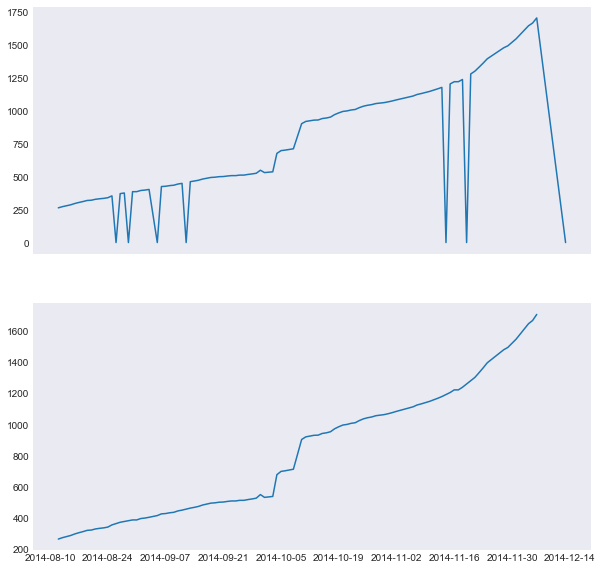

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

deaths = sl.query('Description == "death_confirmed"')
deaths = deaths.set_index(['Date'])
totals = pd.to_numeric(deaths.Totals)
ax1.plot(totals)

# We do an interpolation to remove the 0 errors and remove the last point
totals = totals[:-1]
totals[totals == 0] = np.nan
totals = totals.astype(np.float64)
totals = totals.interpolate()
ax2.plot(totals)

Let's compute the average daily death rate with a linear regression on each month.

Rate for month 8: 6.6003759398496245
Rate for month 9: 4.888964221532426
Rate for month 10: 16.790737920531637
Rate for month 11: 14.738432664317447
Rate for month 12: 31.285714285714295


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Daily average
Country Description Year Month               
sl      Death       2014 8           6.600376
                         9           4.888964
                         10         16.790738
                         11         14.738433
                         12         31.285714
        New case    2014 8          18.550000
                         9          34.413793
                         10         56.714286
                         11         59.904762
                         12         32.600000

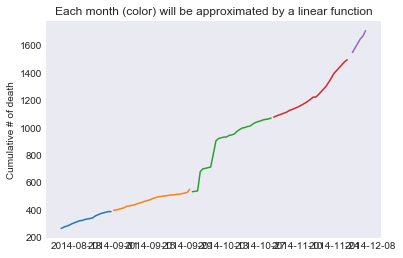

In [19]:
from sklearn import linear_model
months = pd.Series(map(lambda d: d.month,totals.index)).unique()
death_rate = []

for month in months:
    this_month = totals[totals.index.month == month]
    plt.plot(this_month)
    days = np.array(list(map(lambda d: d.day, this_month.index))).reshape(-1, 1)
    lr = linear_model.LinearRegression().fit(days, this_month.values.reshape(-1, 1))
    death_rate.append(lr.coef_[0][0])
    print("Rate for month {}: {}".format(month, lr.coef_[0][0]))

plt.ylabel('Cumulative # of death')
plt.title('Each month (color) will be approximated by a linear function')

# We update our original rates dataframe
death_rate = pd.Series(death_rate)
death_rate.index = months
sl_rates.loc['sl','Death',2014] = death_rate.values.reshape(-1,1)
sl_rates

### Countries together

We concatenate the dataframes and some the daily death count and the daily new case count by country, to get some indight on the data.

In [20]:
all_rates = pd.concat([guinea_rates, liberia_rates, sl_rates])
all_rates.index = all_rates.index.set_levels([['Guinea', 'Liberia', 'Sierra Leone']], level=[0])
all_rates

Daily average
Country      Description Year Month               
Guinea       Death       2014 8           3.400000
                              9           3.562500
                              10         15.000000
             New case    2014 8          12.400000
                              9          13.000000
                              10          6.000000
Liberia      Death       2014 6           2.000000
                              7           4.272727
                              8          23.222222
                              9          36.041667
                              10         28.040000
                              11         13.466667
                              12          0.000000
             New case    2014 6           2.142857
                              7           1.818182
                              8           5.444444
                              9           6.166667
                              10          1.360000
                              11          2.600000
                              12          9.888889
Sierra Leone Death       2014 8           6.600376
                              9           4.888964
                              10         16.790738
                              11         14.738433
                              12         31.285714
             New case    2014 8          18.550000
                              9          34.413793
                              10         56.714286
                              11         59.904762
                              12         32.600000

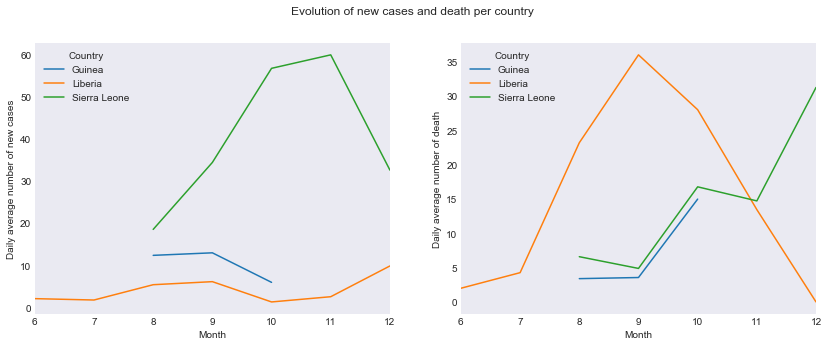

In [21]:
# For visualisation purpose we also plot the data
all_rates.columns = all_rates.columns.get_level_values(0)
all_rates.reset_index(inplace=True)
death_df_plot = all_rates[all_rates.Description == 'Death'].pivot(index='Month', columns='Country', values='Daily average')
new_df_plot = all_rates[all_rates.Description == 'New case'].pivot(index='Month', columns='Country', values='Daily average')

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(14,5));
new_df_plot.plot(ax=ax1);
ax1.set_ylabel('Daily average number of new cases');
death_df_plot.plot(ax=ax2);
ax2.set_ylabel('Daily average number of death');
plt.suptitle('Evolution of new cases and death per country');

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [22]:
# We import the first 9 spreadsheets

dfs = []
for i in range(1,10):
    filename = DATA_FOLDER + '/microbiome/MID{}.xls'.format(i)
    df = pd.read_excel(filename, header=None)
    assert df[0].is_unique # check that the taxons are unique for this barcode o.t.w. we would need to merge them
    df['BARCODE'] = 'MID{}'.format(i)
    dfs.append(df)

df = pd.concat(dfs)
df.columns = ['TAXON', 'COUNT', 'BARCODE']
df.head()

,TAXON,COUNT,BARCODE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,MID1
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID1
2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,MID1
3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,MID1
4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,MID1


In [23]:
# Visualization of the metadata spreadsheet
metadata = pd.read_excel(DATA_FOLDER + "/microbiome/metadata.xls", 'Sheet1')
metadata = metadata.fillna('NA')
metadata = metadata.set_index(['BARCODE', 'GROUP', 'SAMPLE'])
m_index = metadata.index
metadata

,,
BARCODE,GROUP,SAMPLE
MID1,EXTRACTION CONTROL,NA
MID2,NEC 1,tissue
MID3,Control 1,tissue
MID4,NEC 2,tissue
MID5,Control 2,tissue
MID6,NEC 1,stool
MID7,Control 1,stool
MID8,NEC 2,stool
MID9,Control 2,stool


In [24]:
pivot = df.pivot(index='TAXON', columns='BARCODE', values='COUNT')
assert pivot.columns.equals(m_index.get_level_values(0)) # check that metadata are aligned
pivot.fillna('unknown', inplace=True)
pivot.columns = m_index
pivot

BARCODE,MID1,MID2,MID3,MID4,MID5,MID6,MID7,MID8,MID9
GROUP,EXTRACTION CONTROL,NEC 1,Control 1,NEC 2,Control 2,NEC 1,Control 1,NEC 2,Control 2
SAMPLE,NA,tissue,tissue,tissue,tissue,stool,stool,stool,stool
TAXON,,,,,,,,,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",unknown,2,1,unknown,5,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",unknown,14,15,unknown,26,unknown,1,unknown,1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7,23,14,2,28,7,8,unknown,16
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",unknown,unknown,unknown,unknown,1,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",unknown,1,4,unknown,5,1,2,unknown,2
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermodiscus",unknown,unknown,1,unknown,unknown,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",unknown,2,1,unknown,2,unknown,1,unknown,unknown


In [25]:
print('Index is unique' if pivot.index.is_unique else '/!\ Index is not unique')

Index is unique


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [26]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### 1. Describe the type and the value range of each attribute. Indicate and transform the attributes that can be Categorical.

Let's have an overview of the data with the `head`, `describe` and `dtypes` functions.

In [27]:
titanic = pd.read_excel('Data/titanic.xls', header=0)
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [28]:
titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [29]:
# cell types
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [30]:
# show categorical values
categorical = ['pclass', 'sex', 'survived', 'sibsp', 'parch', 'embarked']
for c in categorical:
    print("{}: {}".format(c, titanic[c].unique()))

pclass: [1 2 3]
sex: ['female' 'male']
survived: [1 0]
sibsp: [0 1 2 3 4 5 8]
parch: [0 2 1 4 3 5 6 9]
embarked: ['S' 'C' nan 'Q']


We summarize the required information (type and value range) in the following table:

|             |   pclass    |  survived   | name |        sex        |     age     |  sibsp   |  parch   | ticket |           fare            | cabin |  embarked   | boat | body     | home.dest |
| :---------- | :---------: | :---------: | :--: | :---------------: | :---------: | :------: | :------: | :----: | :-----------------------: | :---: | :---------: | :--: | -------- | :-------: |
| Type        | Categorical | Categorical | Text |    Categorical    |    Float    | Integer  | Integer  |  Text  |           Float           | Text  | Categorical | Text | Integer  |   Text    |
| Value range |   {1,2,3}   |    {0,1}    |  -   | {'male','female'} | \[0.17,80\] | \[0, 8\] | \[0, 9\] |   -    | [0.0, 512.3292] |   -   |  {S, C, Q}  |  -   | [1, 328] |     -     |



The Categorical attributes are the passengers’ class (which could also be considered as ordinal as travel classes benefit from different types of treatment), wether or not they survived, passengers' sex, and their port of embarkation. 
The attributes for which no value range is assigned in the previous table are presented as alphanumerical data and therefore cannot be classified in a logical and useful manner.

#### Remark:
In order to continue this exercise with a cleaner data set, we will drop the columns that will not be useful (name, ticket, destination, body, fare) along with the rows where some necessary data is missing to get an unbiased data set (NaN in cabin, embarkation port, age, sex, travel class). The problem we encountered at this point is that approximately 77% of the passengers do not have a cabin number assigned implying an important loss of data.

In [31]:
titanic.shape

(1309, 14)

In [32]:
cols_drop = ['name', 'ticket', 'fare', 'body', 'home.dest', 'boat']
titanic = titanic.drop(cols_drop, axis=1)

To avoid dropping too many rows we will first check the number of null values assigned to each attribute of the data frame. 

In [33]:
np.count_nonzero(titanic.embarked.isnull())
#np.count_nonzero(titanic.survived.isnull())
#np.count_nonzero(titanic.pclass.isnull())
#np.count_nonzero(titanic.sex.isnull())
#np.count_nonzero(titanic.cabin.isnull())
titanic.embarked[titanic.embarked.isnull()]

168    NaN
284    NaN
Name: embarked, dtype: object

There are 1014 NaN in the cabin column, 2 in the embarked column none in the sex, survived and passenger's class columns. Therefore, we will create a second set of data to compute the proportions of passengers in each floor by deleting the NaN values. As only 2 embarkation ports are missing, at positions 168 and 284, we will manually assign them a port uniformly at random as it will not affect greatly the obtained result.

In [34]:
em = ['S','C','Q']
titanic.set_value(168, 'embarked', random.choice(em))
titanic.set_value(284, 'embarked', random.choice(em))
titanic_nonullcabin = titanic.dropna(axis=0)

In [35]:
print('Shape of titanic dataset:', titanic.shape)
print('Shape of titanic dataset with valid cabin:', titanic_nonullcabin.shape)

Shape of titanic dataset: (1309, 8)
Shape of titanic dataset with valid cabin: (272, 8)


Passengers' class, sex, wether or not they survived and the port on which they embarked are all attributes that can and will be considered as Categorical with the exception of survived which for statistical purposes (in questions 5 and 6) will be better used as a string. 

In [36]:
# transforming categorical values into category type 
titanic.pclass = titanic.pclass.astype('category')
titanic.survived = titanic.survived.astype('category') # TODO
titanic.sex = titanic.sex.astype('category')
titanic.embarked = titanic.embarked.astype('category')

### 2. Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.

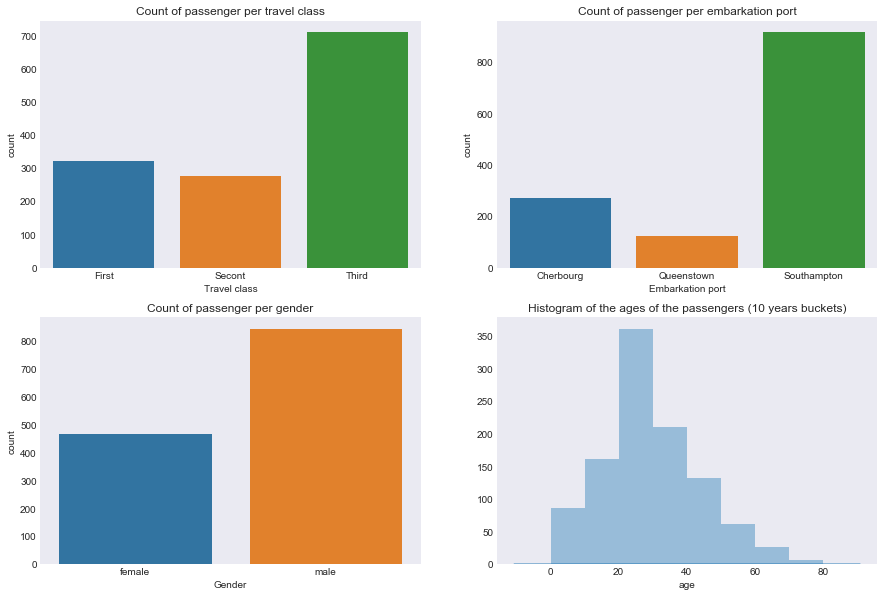

In [37]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10));

g = sns.countplot(x="pclass", data=titanic, ax=ax1);
g.set_xlabel('Travel class');
g.set_title('Count of passenger per travel class');
g.set_xticklabels(['First', 'Secont', 'Third'])

# TODO ignore the NAN here
g = sns.countplot(x="embarked", data=titanic, ax=ax2);
g.set_xlabel('Embarkation port');
g.set_title('Count of passenger per embarkation port');
g.set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'])

g = sns.countplot(x="sex", data=titanic, ax=ax3);
g.set_xlabel('Gender')
g.set_title('Count of passenger per gender');

g = sns.distplot(a=titanic.age.dropna(), bins=8, hist_kws = {'normed': False}, ax=ax4);
g.set_title('Histogram of the ages of the passengers (10 years buckets)');

### 3. Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.

Here we decided for the passengers assigned to two rooms to take the first one.

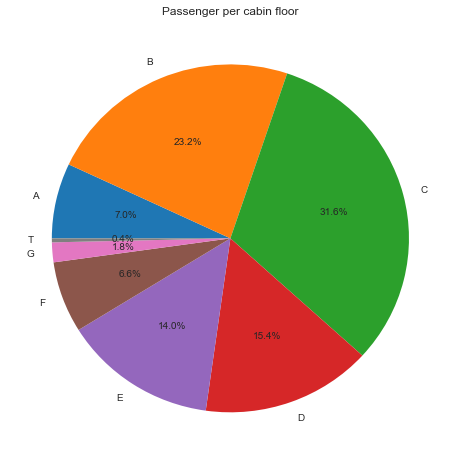

In [38]:
cabins = titanic_nonullcabin.cabin
cabins = cabins.astype(str).str[0]
freqs = cabins.value_counts(normalize=True)
freqs = freqs.to_frame().sort_index()
g = freqs.cabin.plot.pie(startangle=180, figsize=(8,8), counterclock=False, autopct='%1.1f%%');
g.set_title('Passenger per cabin floor');
g.set_ylabel('');

### 4. For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

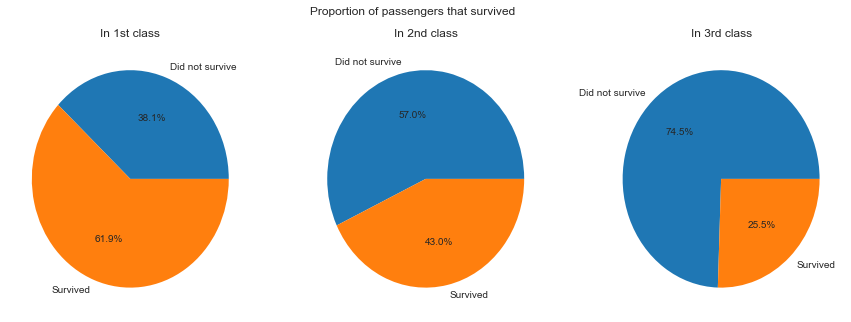

In [40]:
f, axs = plt.subplots(1, 3, figsize=(15,5));

plt.suptitle("Proportion of passengers that survived")
titles = ["1st", "2nd", "3rd"]
titles = ["In {} class".format(t) for t in titles]

for i, ax in enumerate(axs):
    class_ = i + 1
    class_survived = titanic.query('pclass == @class_').survived
    freqs = class_survived.value_counts(normalize=True)
    freqs = freqs.to_frame().sort_index()
    freqs.index = pd.Index(['Did not survive', 'Survived'])
    g = freqs.survived.plot.pie(autopct='%1.1f%%', shadow=False, ax=ax)
    g.set_title(titles[i])
    g.set_ylabel("")


### 5. Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

In [41]:
titan = titanic[['pclass', 'sex', 'survived']].copy()
titan.survived = pd.to_numeric(titan.survived)
survival_rate = titan.groupby(['pclass', 'sex']).mean() # survival rate is given by the mean of the 0, 1 values
survival_rate

survived
pclass sex             
1      female  0.965278
       male    0.340782
2      female  0.886792
       male    0.146199
3      female  0.490741
       male    0.152130

In [42]:
survival_rate = survival_rate.reset_index() # flatten index

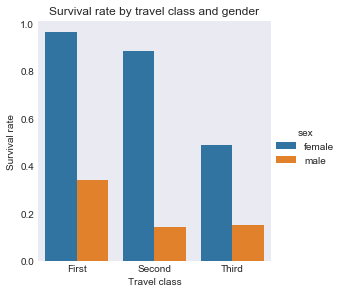

In [43]:
g = sns.factorplot(data=survival_rate, x='pclass', y='survived', hue='sex', kind="bar");
g.ax.set_title('Survival rate by travel class and gender');
g.ax.set_xlabel('Travel class');
g.ax.set_xticklabels(['First', 'Second', 'Third']);
g.ax.set_ylabel('Survival rate');

### 6. Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.

We use the median to separate our population into 2 equally populated age categories.

In [44]:
threshold = titanic.age.median()
if int(threshold) == threshold:
    threshold = int(threshold)

titanic['age_class'] = ["> {}".format(threshold) if x > threshold 
                        else "<= {}".format(threshold) for x in titanic.age]
titanic['age_class'] = titanic['age_class'].astype('category')
sub_titanic = titanic[['age_class','pclass', 'sex', 'survived']].copy()
sub_titanic.survived = pd.to_numeric(titan.survived)
grouped = sub_titanic.groupby(['age_class','pclass', 'sex']).mean()
grouped

survived
age_class pclass sex             
<= 28     1      female  0.961538
                 male    0.416667
          2      female  0.898305
                 male    0.206897
          3      female  0.520231
                 male    0.154891
> 28      1      female  0.967391
                 male    0.302521
          2      female  0.872340
                 male    0.083333
          3      female  0.372093
                 male    0.144000

In [45]:
print('Index is unique' if grouped.index.is_unique else '/!\ Index is not unique')

Index is unique
